## Pathway and Cell-Type Enrichment Analysis of Fetal-specific eGenes

In [27]:
options(stringsAsFactors = F)
setwd("~/Github/Fetal_metaQTL/")

library(tidyverse)
#BiocManager::install('gprofiler2')
library(gprofiler2)
library(openxlsx)

source("code/06-analyses/fisher_overlap.R")

1. Load data from Table S1

In [55]:
tableS1 = openxlsx::read.xlsx("data/manuscript/ST1.xlsx",sheet="ST1-2-eGene")
fetal_only_eGenes = tableS1 %>% filter(fetal_only=="yes") %>% select(pid, gene_name, gene_type, qval) %>% as_tibble()
fetal_all_eGenes = tableS1 %>% select(pid) %>% pull()
head(fetal_only_eGenes)

pid,gene_name,gene_type,qval
<chr>,<chr>,<chr>,<dbl>
ENSG00000000419,DPM1,protein_coding,0.00147123
ENSG00000002746,HECW1,protein_coding,0.00100023
ENSG00000004478,FKBP4,protein_coding,0.01215830
ENSG00000005812,FBXL3,protein_coding,0.04243070
ENSG00000006025,OSBPL7,protein_coding,0.02392810
ENSG00000006062,MAP3K14,protein_coding,0.01218350


In [20]:
library(gprofiler2)

## Pathway analysis with gProfileR
## Note: ordered query here because genes are ranked by DTU significance. Usually this will be F
## Always use the matching background gene set
path = gprofiler2::gost(query=fetal_only_eGenes$pid,ordered_query = F,correction_method = 'fdr',
                        custom_bg = fetal_all_eGenes, sources = c("GO","KEGG", "REACTOME"))


Detected custom background input, domain scope is set to 'custom'



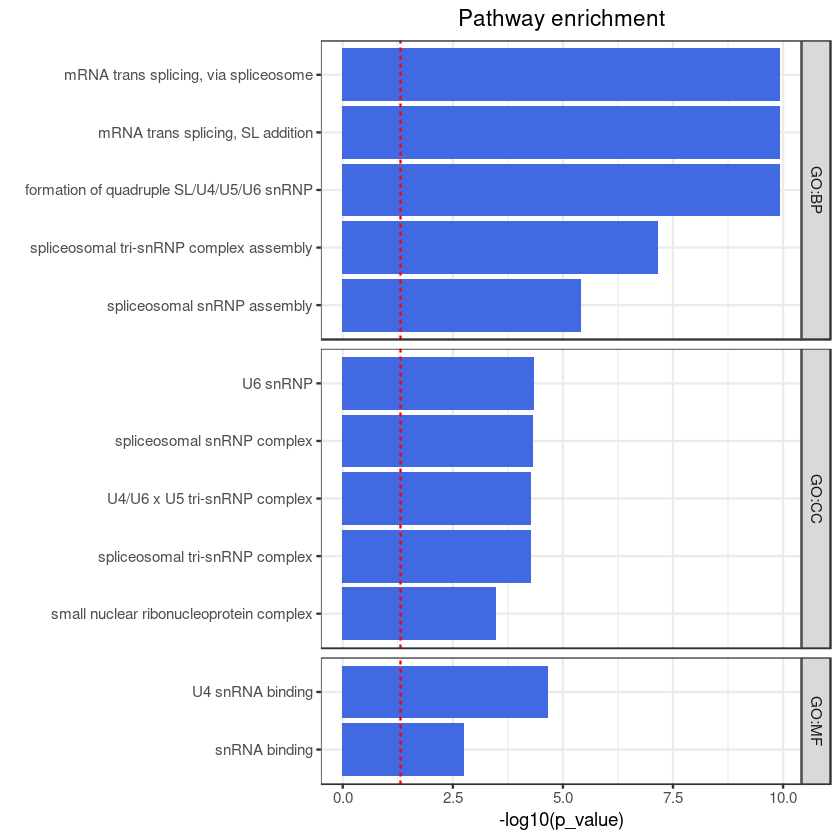

In [75]:
df_path = as_tibble(path$result)

## Plot top 5 results per database
panelA <- df_path %>% group_by(source) %>% slice_min(p_value,n=5) %>% ungroup() %>%
  ggplot(aes(x=reorder(term_name, -p_value), y=-log10(p_value), fill=source)) + geom_bar(stat='identity',fill='royalblue') + coord_flip() + theme_bw() + labs(x="")  + 
  facet_grid(source~., space = 'free', scales='free') + theme(legend.position = 'none') + 
geom_hline(yintercept = -log10(0.05), lty=2,color='red') + ggtitle("Pathway enrichment") + theme(plot.title = element_text(hjust=.5))
panelA


In [57]:
df_path %>% arrange(p_value) %>% head()


query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents
<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>
query_1,TRUE,1.210070e-10,27,2389,25,0.010464630,0.9259259,GO:0000353,GO:BP,formation of quadruple SL/U4/U5/U6 snRNP,9958,147,"GO:0022618, GO:0045291"
query_1,TRUE,1.210070e-10,27,2389,25,0.010464630,0.9259259,GO:0000365,GO:BP,"mRNA trans splicing, via spliceosome",9958,149,GO:0000398
query_1,TRUE,1.210070e-10,27,2389,25,0.010464630,0.9259259,GO:0045291,GO:BP,"mRNA trans splicing, SL addition",9958,13184,GO:0000365
query_1,TRUE,7.226205e-08,35,2389,27,0.011301800,0.7714286,GO:0000244,GO:BP,spliceosomal tri-snRNP complex assembly,9958,110,GO:0000387
query_1,TRUE,4.047260e-06,46,2389,30,0.012557555,0.6521739,GO:0000387,GO:BP,spliceosomal snRNP assembly,9958,161,"GO:0000398, GO:0022618"
query_1,TRUE,2.264497e-05,24,2389,19,0.007953118,0.7916667,GO:0030621,GO:MF,U4 snRNA binding,9958,4916,GO:0017069


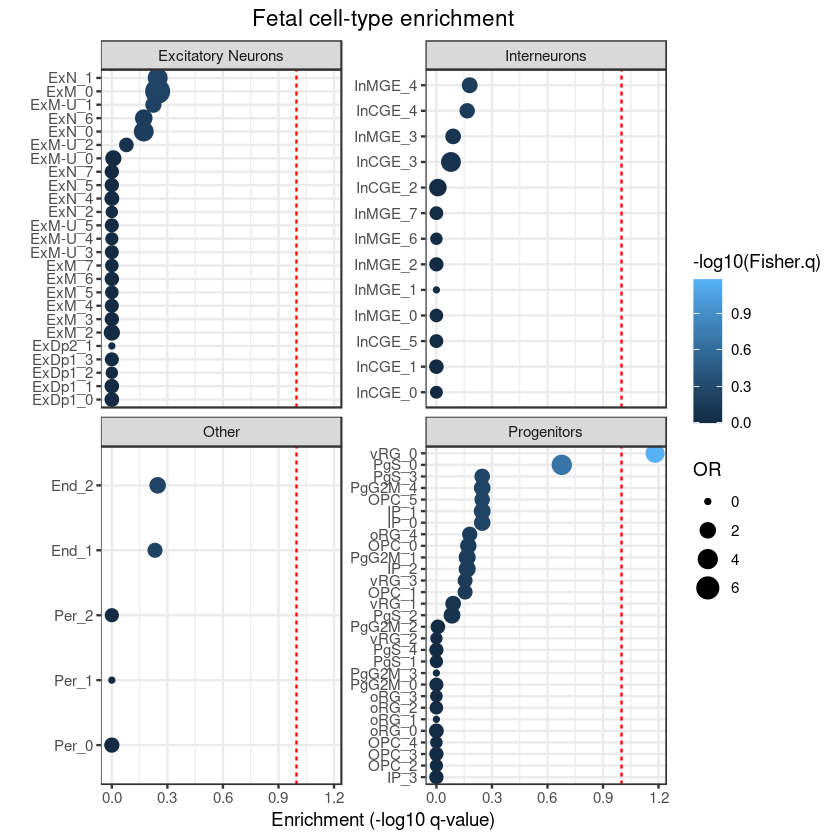

In [76]:
# Cell type markers from fetal brain scRNAseq
# Load poliodakis et al markers (Table S4)
celltypemarkers <- openxlsx::read.xlsx('https://www.cell.com/cms/10.1016/j.neuron.2019.06.011/attachment/508ae008-b926-487a-b871-844a12acc1f8/mmc5', sheet='Cluster enriched genes') %>% as_tibble()

celltypemarkers.tableS5 = openxlsx::read.xlsx('https://www.cell.com/cms/10.1016/j.neuron.2019.06.011/attachment/ec1863fa-0dfc-405c-928c-c5ca96115667/mmc6', sheet='Sub-cluster enriched genes') %>% as_tibble()
markers.bg = unique(c(celltypemarkers$Ensembl,celltypemarkers.tableS5$Ensembl))
markers.bg2 <- tableS1 %>% filter(gene_type == "protein_coding") %>%  select(pid) %>% pull()

  df_fisher = data.frame()
  for(this_cell in unique(celltypemarkers.tableS5$Subcluster)) {
    marker_genes = celltypemarkers.tableS5 %>% filter(Subcluster == this_cell) %>% dplyr::select(Ensembl) %>% pull()
    enrichment = ORA(fetal_only_eGenes$pid, marker_genes, fetal_all_eGenes, markers.bg2)
    df_fisher = rbind(df_fisher, data.frame(set="Fetal-only-eGenes", cell=this_cell, as.data.frame(t(enrichment))))
  }

    df_fisher$OR = as.numeric(df_fisher$OR)
  df_fisher$Fisher.p = as.numeric(df_fisher$Fisher.p)
  df_fisher$Fisher.p[df_fisher$OR<1] = 1
  df_fisher$Fisher.q = p.adjust(df_fisher$Fisher.p,'fdr')
  
  df_fisher$CellClass = "Progenitors"
  df_fisher$CellClass[grep("Ex",df_fisher$cell)] = "Excitatory Neurons"
  df_fisher$CellClass[grep("In",df_fisher$cell)] = "Interneurons"
  df_fisher$CellClass[grep("End",df_fisher$cell)] = "Other"
  df_fisher$CellClass[grep("Per",df_fisher$cell)] = "Other"
  df_fisher$CellClass[grep("Per",df_fisher$cell)] = "Other"
  
panelB <- ggplot(df_fisher,aes(x=reorder(cell, -Fisher.q), y= -log10(Fisher.q), size=OR, color=-log10(Fisher.q))) +
        geom_point() + coord_flip() + facet_wrap(~CellClass, scales = 'free_y') + theme_bw() +
    geom_hline(yintercept = 1,lty=2,color='red') + labs(y='Enrichment (-log10 q-value)',x='') + 
ggtitle("Fetal cell-type enrichment")+ theme(plot.title = element_text(hjust=.5))
panelB
  

In [54]:
df_fisher %>% arrange(Fisher.q)

set,cell,OR,Fisher.p,X.95.CI,X.95.CI.1,Overlap,Reference.List,Input.List,Background,X..List.Overlap,Fisher.q,CellClass
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
Fetal-only-eGenes,vRG_0,3.297347,0.000915418,1.57129601795046,6.55159304529308,13,43,737,6278,30.2,0.0659101,Other
Fetal-only-eGenes,PgS_0,4.076542,0.005839392,1.37240217300757,11.032189582091,7,20,737,6278,35,0.2102181,Other
Fetal-only-eGenes,PgS_3,1.639604,0.066855735,0.936845210406715,2.73449445469818,19,107,737,6278,17.8,0.5656805,Other
Fetal-only-eGenes,PgG2M_4,2.085499,0.070986923,0.820629188598418,4.69767122220521,8,37,737,6278,21.6,0.5656805,Other
Fetal-only-eGenes,IP_0,2.015658,0.078566733,0.795329694959425,4.52184966580747,8,38,737,6278,21.1,0.5656805,Other
Fetal-only-eGenes,IP_1,2.163534,0.036289564,0.951366277932378,4.48763916773158,10,45,737,6278,22.2,0.5656805,Other
Fetal-only-eGenes,ExN_1,3.776744,0.024146851,1.01002851198311,12.1678088419601,5,15,737,6278,33.3,0.5656805,Excitatory Neurons
Fetal-only-eGenes,ExM_0,7.531572,0.070258530,0.545176261811707,104.073635782812,2,4,737,6278,50,0.5656805,Excitatory Neurons
Fetal-only-eGenes,OPC_5,1.595674,0.062462752,0.940257349587002,2.59301461743001,21,121,737,6278,17.4,0.5656805,Other


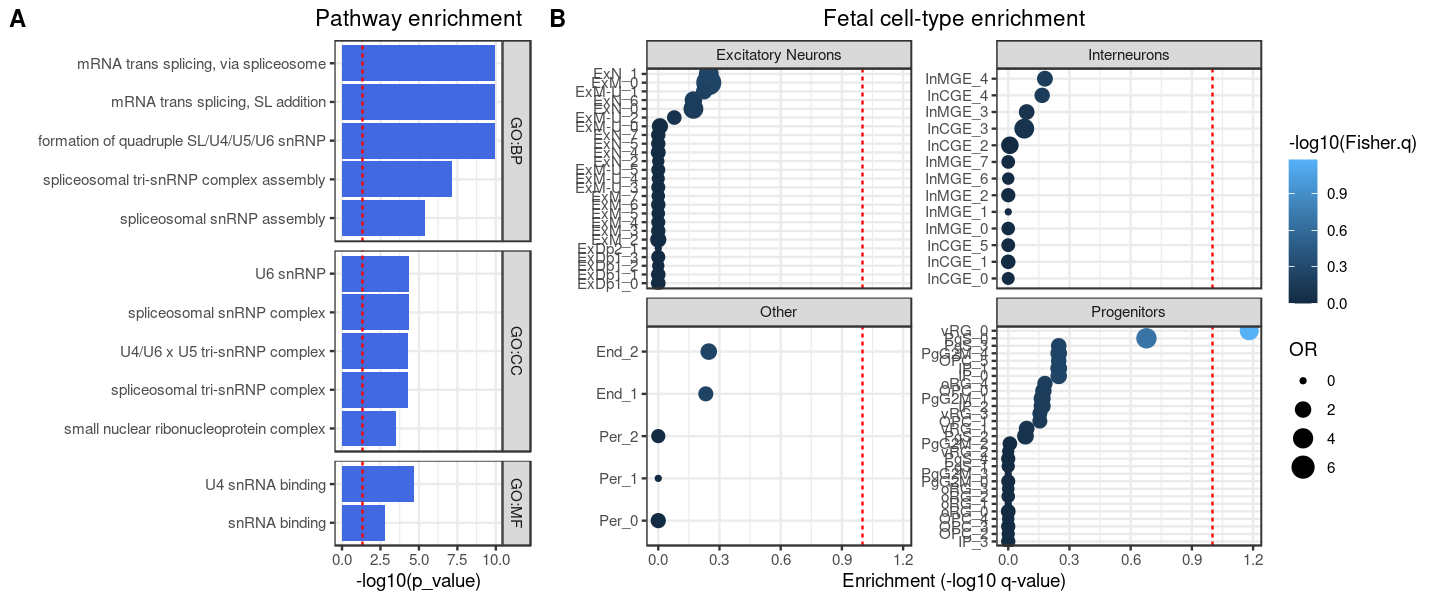

In [86]:
options(repr.plot.width=12, repr.plot.height=5)
cowplot::plot_grid(plotlist = list(panelA, panelB),labels="AUTO",rel_widths = c(.6,1))